In [1]:
require 'Utils'
require 'Net1'
require 'VGG'
require 'optim'

In [2]:
function get_x_feedback(uv_feedback,im_batch,layer_nums,VGG_net)
    local count = 1;
    local hc_batch = nil;
    local im_feedback = image.yuv2rgb(torch.cat(image.rgb2y(im_batch[count]),image.scale(uv_feedback[count],64,64),1))
    -- dirty coding for now
    local hc_temp = get_VGG_hypercolumns(im_feedback,VGG_net,layer_nums)
    local hc_size = hc_temp:size();
    local hc_batch = hc_temp:reshape(1,hc_size[1], hc_size[2], hc_size[3] );
    local num_images = im_batch:size()[1]
    for count=2,num_images do
        im_feedback = image.yuv2rgb(torch.cat(image.rgb2y(im_batch[count]),image.scale(uv_feedback[count],64,64),1))
        hc_temp = get_VGG_hypercolumns(im_feedback,VGG_net,layer_nums)
        hc_temp = hc_temp:reshape(1,hc_size[1], hc_size[2], hc_size[3] );
        hc_batch = torch.cat(hc_batch, hc_temp,1)
    end
    return hc_batch
end

In [ ]:
local dtype = 'torch.DoubleTensor'

VGG_net = load_VGG();
model = BasicConvNet2()
local params, grad_params = model:getParameters()
local crit = nn.MSECriterion():type(dtype)

-- Set up some variables we will use below
local train_loss_history = {}

-- Contains all the meta parameters
local opt = {num_iterations=50, print_every=1, learning_rate=0.01, batch_size = 16, layers = {3,9}}

--Triming the network will the last required layer 
trim_net(VGG_net, opt.layers[#opt.layers])

-- Get a minibatch and run the model forward, maybe timing it
im_batch, x = create_hypercolumn_dataset_random_bw(opt.batch_size, VGG_net, opt.layers);
uv_images, y_images = create_yuv_images(im_batch,28,28)
uv_images = uv_images + 0.5

-- Datatype standardization 
x, uv_images = x:type(dtype), uv_images:type(dtype)

-- Loss function that we pass to an optim method
local function f(w)
--  assert(w == params)
  grad_params:zero()

--   -- Get a minibatch and run the model forward, maybe timing it
--   local im_batch, x = create_hypercolumn_dataset_random_bw(opt.batch_size, VGG_net, opt.layers);
--   local uv_images, y_images = create_yuv_images(im_batch,28,28)
  
--   -- Datatype standardization 
--   x, uv_images = x:type(dtype), uv_images:type(dtype)

  local scores = model:forward(x)
  local uv_output = model.output - 0.5
  x = get_x_feedback(uv_output,im_batch,opt.layers,VGG_net)
  local loss   = crit:forward(scores, uv_images)

  -- Run the Criterion and model backward to compute gradients, maybe timing it
  local grad_scores = crit:backward(scores, uv_images)
  model:backward(x, grad_scores)

  return loss, grad_params
end


-- Train the model!
local optim_config = {learningRate = opt.learning_rate}
local num_iterations = opt.num_iterations
for i = 1, num_iterations do

  -- Take a gradient step and maybe print
  -- Note that adam returns a singleton array of losses
  local _, loss = optim.adam(f, params, optim_config)
  table.insert(train_loss_history, loss[1])
  if opt.print_every > 0 and i % opt.print_every == 0 then
    local msg = ' i = %d / %d, loss = %f'
    local args = {msg,  i, num_iterations, loss[1]}
    print(string.format(unpack(args)))
  end
end


Successfully loaded ../../Data/VGG_caffe/VGG_ILSVRC_16_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3


conv3_1: 256 128 3 3
conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


 i = 1 / 50, loss = 0.013616	


In [ ]:
function y2rgb(y_temp)
    im_y = torch.cat(y_temp,y_temp,1);
    im_y = torch.cat(im_y,y_temp,1);
    return im_y
end

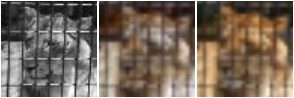

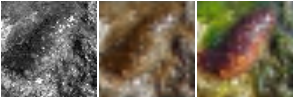

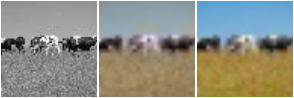

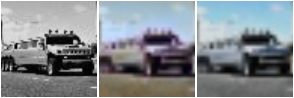

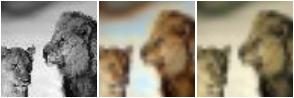

In [10]:
uv_op = model.output - 0.5
for i = 2,6 do
    size = 96
    itorch.image({image.scale(y2rgb(image.rgb2y(im_batch[i])),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_op[i],1)),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i]-0.5,1)),size,size)})
    -- itorch.image(image.scale(im_batch[i],size,size))
end

In [13]:
local layer_nums = {3,9}
local num_images = 16;
val_im_batch,val_hc_batch = create_hypercolumn_dataset_random_bw(num_images, VGG_net,layer_nums)
-- val_im_batch,val_hc_batch = create_hypercolumn_dataset_random(num_images, layer_nums);
hc_size = val_hc_batch:size()
num_hypercolumns = hc_size[2]
uv_images,y_images = create_yuv_images(val_im_batch,28,28)
model:forward(val_hc_batch);
val_uv = model.output -0.5;

Input, Output, Original	


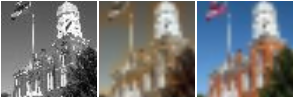

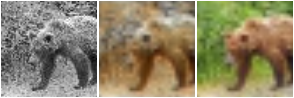

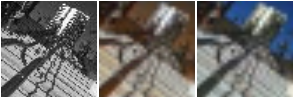

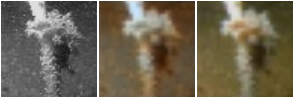

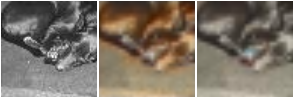

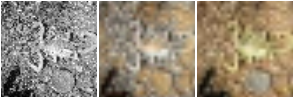

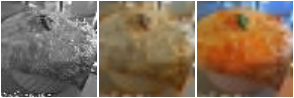

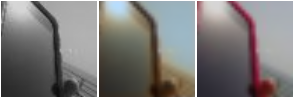

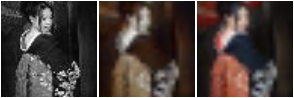

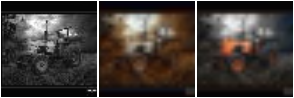

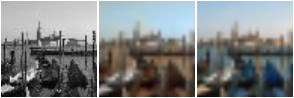

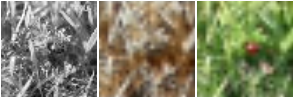

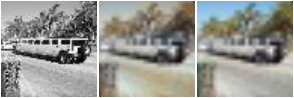

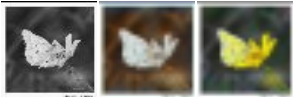

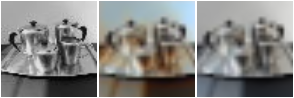

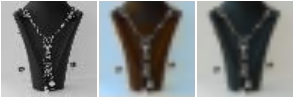

In [17]:
im_batch = val_im_batch
uv_op = val_uv
print("Input, Output, Original")
for i = 1,16 do
    size = 96
    itorch.image({image.scale(y2rgb(image.rgb2y(im_batch[i])),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_op[i],1)),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i],1)),size,size)})
    -- itorch.image(image.scale(im_batch[i],size,size))
end

In [ ]:
depth = 193
net = BasicConvNet2();
criterion = nn.MSECriterion()
print('MSEcriterion defined')

In [ ]:
layer_nums = {3,9}
num_images = 8;
decay = 0.99;
local train_loss_history = {}
for i = 1,1 do
    --im_batch,hc_batch = create_hypercolumn_dataset_random_bw(num_images, layer_nums, VGG_net);
    hc_size = hc_batch:size()
    num_hypercolumns = hc_size[2]
    uv_images,y_images = create_yuv_images(im_batch,28,28)
    lr = .2;
    v  = 0
    mu = .99
    for j = 1,100 do
        loss = criterion:forward(net:forward(hc_batch), uv_images+0.5)
        print("batch: ".. i .. ") iter:" .. j .. " " .. loss)
        loss = net.output
        net:backward(hc_batch, criterion:backward(loss, uv_images+0.5))
        net:updateParameters(lr)
        table.insert(train_loss_history, loss)
    end
end

In [ ]:
uv_op = net.output-0.5;

In [ ]:
itorch.image(torch.cat(y_images,uv_op,2))

In [ ]:
i = 4
size = 28
itorch.image(image.scale(y_images[i],size,size))
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_op[i],1)),size,size))
itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i],1)),size,size))
itorch.image(image.scale(im_batch[i],size,size))

In [ ]:
local layer_nums = {3,9}
local num_images = 8;
val_im_batch,val_hc_batch = create_hypercolumn_dataset_random_bw(num_images, layer_nums)
-- val_im_batch,val_hc_batch = create_hypercolumn_dataset_random(num_images, layer_nums);
hc_size = val_hc_batch:size()
num_hypercolumns = hc_size[2]
uv_images,y_images = create_yuv_images(val_im_batch,28,28)
net:forward(val_hc_batch);
val_uv = net.output -0.5;

In [ ]:
local num_images = 8;
for iter=1,num_images do
    itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[iter],val_uv[iter],1)),224,224))
    itorch.image(image.scale(im_batch[iter],224,224))
end

In [ ]:
local layer_nums = {3,9}
local num_images = 8;
-- val_im_batch,val_hc_batch = create_hypercolumn_dataset_random_bw(num_images, layer_nums)
val_im_batch,val_hc_batch = create_hypercolumn_dataset_random(num_images, layer_nums);
hc_size = val_hc_batch:size()
num_hypercolumns = hc_size[2]
uv_images,y_images = create_yuv_images(val_im_batch,28,28)
net:forward(val_hc_batch);
val_uv = net.output -0.5;

In [ ]:
local num_images = 8;
for iter=1,num_images do
    itorch.image(image.scale(image.yuv2rgb(torch.cat(y_images[iter],val_uv[iter],1)),224,224))
    itorch.image(image.scale(im_batch[iter],224,224))
end